<a href="https://colab.research.google.com/github/Dly27/stock-forecast/blob/main/stock_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Forecast

## Project Description
This project aims to forecast stock prices using an LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit). The dataset used is the historical stock prices of Apple Inc. (AAPL) from January 1, 2021, to January 1, 2024. The main steps involved in this analysis are:

1. Fetching stock data from Alpha Vantage API
2. Preprocessing the data and creating technical indicators (90-day and 30-day SMA)
3. Use features such as : OHLCV , SMAs
4. Splitting the data into training, validation, and testing sets
5. Training model on the preprocessed data
6. Evaluating the model's performance on the testing set



# Installation and imports

In [ ]:
!pip install alpha_vantage

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from alpha_vantage.timeseries import TimeSeries
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

ALPHA_VANTAGE_API_KEY = 'VC2S9T9RSVXMPOP0'

# Fetch and prepare data

In [163]:
def fetch_stock_data(symbol, start_date, end_date):
    ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
    data, meta_data = ts.get_daily(symbol=symbol, outputsize='full')
    data = data[(data.index >= start_date) & (data.index <= end_date)]
    return data

def prepare_data(data):
    features = data[['1. open', '2. high', '3. low', '4. close', '5. volume', '30_day_sma']]
    target = data['4. close']
    return features, target


Fetch data from alpha vantage and split data based on dates

In [164]:
stock_data = fetch_stock_data('AAPL', '2021-01-01', '2024-03-01')

# Calculate SMAs on the entire stock_data
stock_data['30_day_sma'] = stock_data['4. close'].rolling(window=30, min_periods=1).mean()

# Split the data into train_val and test sets
train_val_data = stock_data.loc[:pd.Timestamp('2023-04-30')]
test_data = stock_data.loc[pd.Timestamp('2023-05-01'):]

train_val_features, train_val_target = prepare_data(train_val_data)
test_features, test_target = prepare_data(test_data)


In [165]:
print(stock_data.head)

<bound method NDFrame.head of             1. open   2. high   3. low  4. close    5. volume  90_day_sma  \
date                                                                        
2024-04-01  171.190  171.2500  169.475    170.03   43772506.0  170.030000   
2024-03-28  171.750  172.2300  170.510    171.48   65672690.0  170.755000   
2024-03-27  170.410  173.6000  170.110    173.31   60273265.0  171.606667   
2024-03-26  170.000  171.4200  169.580    169.71   57388449.0  171.132500   
2024-03-25  170.565  171.9400  169.450    170.85   54288328.0  171.076000   
...             ...       ...      ...       ...          ...         ...   
2021-01-08  132.430  132.6300  130.230    132.05  105158245.0  128.971889   
2021-01-07  128.360  131.6300  127.860    130.92  109578157.0  129.039333   
2021-01-06  127.720  131.0499  126.382    126.60  155087970.0  129.043000   
2021-01-05  128.890  131.7400  128.430    131.01   97664898.0  129.082556   
2021-01-04  133.520  133.6116  126.760    129.

Plot stock prices and SMAs

In [ ]:
plt.figure(figsize=(12, 6))
# Plot train_val_data
plt.plot(train_val_data.index, train_val_data['4. close'], color='blue', label='Train/Val Data')
plt.plot(train_val_data.index, train_val_data['30_day_sma'], color='green', label='30-day SMA (Train/Val)')

# Plot test_data
plt.plot(test_data.index, test_data['4. close'], color='red', label='Test Data')
plt.plot(test_data.index, test_data['30_day_sma'], color='green', label='30-day SMA (Test)')

plt.title('Apple (AAPL) Stock Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

# Data Preprocessing

Scale training and test data, reshape input data for LSTM model

In [146]:
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42, shuffle=False)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])

datasets = [X_train, X_validation, X_test]
scaled_datasets = []
for dataset in datasets:
    scaled_dataset = pipeline.fit_transform(dataset)
    scaled_datasets.append(scaled_dataset)

X_train_scaled, X_validation_scaled, X_test_scaled = scaled_datasets

# Create input sequences
time_steps = 30
step_size = 5

X_train_lstm = []
y_train_lstm = []

for i in range(time_steps, len(X_train_scaled) - time_steps, step_size):
    X_train_lstm.append(X_train_scaled[i:i + time_steps])
    y_train_lstm.append(y_train[i + time_steps])

X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2])

# Prepare validation and test sequences
X_validation_lstm, y_validation_lstm = [], []
X_test_lstm, y_test_lstm = [], []

for i in range(time_steps, len(X_validation_scaled) - time_steps, step_size):
    X_validation_lstm.append(X_validation_scaled[i:i + time_steps])
    y_validation_lstm.append(y_validation[i + time_steps])

for i in range(time_steps, len(X_test_scaled) - time_steps, step_size):
    X_test_lstm.append(X_test_scaled[i:i + time_steps])
    y_test_lstm.append(y_test[i + time_steps])

X_validation_lstm, y_validation_lstm = np.array(X_validation_lstm), np.array(y_validation_lstm)
X_test_lstm, y_test_lstm = np.array(X_test_lstm), np.array(y_test_lstm)

X_validation_lstm = X_validation_lstm.reshape(X_validation_lstm.shape[0], X_validation_lstm.shape[1], X_validation_lstm.shape[2])
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], X_test_lstm.shape[2])



# Model training and testing

Train LSTM model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])


optimizer = tf.keras.optimizers.Adam(learning_rate=5, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_data=(X_validation_lstm, y_validation_lstm),
    callbacks=[early_stopping]
)



Train GRU model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_data=(X_validation_lstm, y_validation_lstm),
    callbacks=[early_stopping]
)

Predict values

In [ ]:
# Generate predictions on the test set
predictions = model.predict(X_test_lstm)

# Create arrays for test dates and actual prices
X_test_lstm = []
y_test_lstm = []
test_dates = []

for i in range(time_steps, len(X_test_scaled) - time_steps, step_size):
    X_test_lstm.append(X_test_scaled[i:i + time_steps])
    y_test_lstm.append(y_test[i + time_steps])
    test_dates.append(stock_data.index[i + time_steps])

X_test_lstm, y_test_lstm = np.array(X_test_lstm), np.array(y_test_lstm)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], X_test_lstm.shape[2])

# Reshape predictions to match y_test_lstm
predictions = predictions.reshape(-1)


# Model Evaluation

Error analysis

In [ ]:
mse = mean_squared_error(y_test_lstm, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_lstm, predictions)
directional_accuracy = np.sum((np.sign(y_test_lstm[1:] - y_test_lstm[:-1]) == np.sign(predictions[1:] - predictions[:-1]))) / len(y_test_lstm[1:])
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Directional Accuracy:", directional_accuracy)

Plot actual vs predicted price

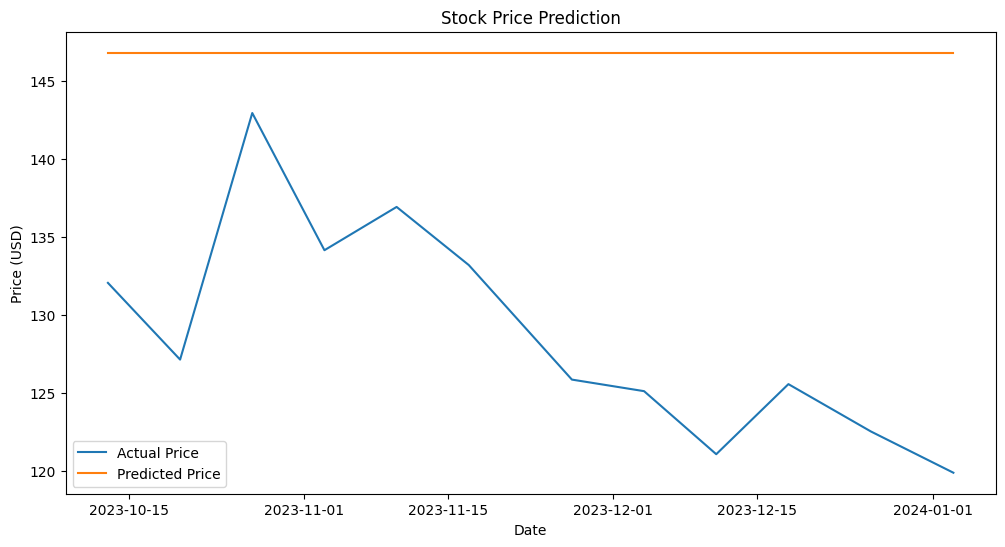

In [167]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_lstm, label='Actual Price')
plt.plot(test_dates, predictions, label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
model.summary()

# GARCH model


In [ ]:
!pip install arch

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001491. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 3720938.5003060666
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1310983.3406221436
Iteration:      3,   Func. Count:     28,   Neg. LLF: 878568.3484595474
Iteration:      4,   Func. Count:     40,   Neg. LLF: 85833741664633.88
Iteration:      5,   Func. Count:     51,   Neg. LLF: -687.1165975061065
Optimization terminated successfully    (Exit mode 0)
            Current function value: -687.1165978142207
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 5


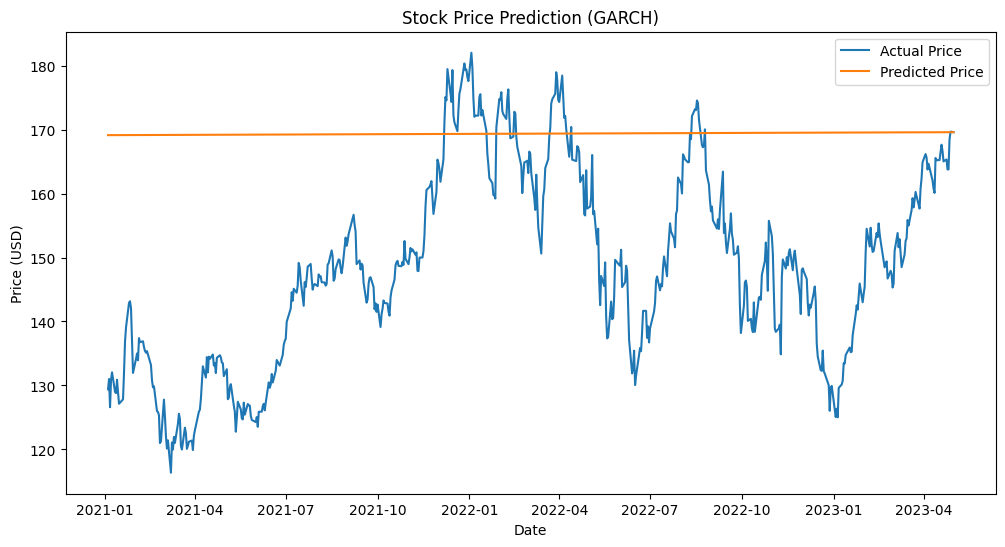

Mean Squared Error (MSE): 661.7193430542729
Root Mean Squared Error (RMSE): 25.723906061371647
Mean Absolute Error (MAE): 21.959053996577524


In [168]:
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt

# Calculate log returns
returns = stock_data['4. close'].pct_change().dropna()

# Split the data into train and test sets
train_data = returns.loc[:pd.Timestamp('2023-04-30')]
test_data = returns.loc[pd.Timestamp('2023-05-01'):]

# Fit a GARCH(1,1) model to the training set
garch = arch_model(train_data, vol='GARCH', p=1, q=1, mean='constant')
model = garch.fit()

# Generate forecasts for the test set
forecasts = model.forecast(horizon=len(test_data), reindex=False)
mean_forecasts = forecasts.mean.values.flatten()

# Reconstruct the actual stock prices from the log returns
actual_prices = stock_data['4. close'].loc[test_data.index]

# Reconstruct the predicted stock prices from the mean forecasts
predicted_prices = actual_prices.iloc[0] * (1 + np.cumsum(mean_forecasts))

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices.index, actual_prices, label='Actual Price')
plt.plot(actual_prices.index, predicted_prices, label='Predicted Price')
plt.title('Stock Price Prediction (GARCH)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Calculate additional evaluation metrics
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)